# **Influencer Scouting**

In today’s business scenario, many brands encounter difficulties in searching and hiring suitable influencers. Researchers have been studying various aspects of this type of marketing; nevertheless, most previous works have given little consideration to categorizing the influencers’ interests, which are crucial in maximizing the marketing effect. Hence, our aim is to determine the influencers’ category based on their social media posts, such as those on Instagram.






# **Setup**

### 1. Install PySpark and related dependencies

In [1]:
from IPython.display import clear_output 

!pip install pyspark
!pip install sparktorch
!pip install transformers
!pip install nltk
!pip install ipywidgets
!pip install scikit-learn
!pip install seaborn
!pip install sparknlp

clear_output()

### 2. Import useful PySpark packages

In [1]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.group import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.window import Window
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.evaluation import *
from sklearn.metrics import *
from pyspark.ml.tuning import *
from pyspark.ml.linalg import VectorUDT, Vectors
import sparknlp 
from sparknlp.base import *
from sparknlp.annotator import *        
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import os
from PIL import Image
import io
import numpy as np
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import *
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import *
from sparktorch import serialize_torch_obj, SparkTorch
from PIL import Image
import math
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple
from torch import optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
print()

# Clear cache
torch.cuda.empty_cache()

#Additional Info when using cuda
if device.type == 'cuda':
    print('Device:', torch.cuda.get_device_name(0))
    print('Allocated:', torch.cuda.memory_allocated(0)/1024**3, 'GB')
    print('Cached:   ', torch.cuda.memory_reserved(0)/1024**3, 'GB')

Using device: cuda

Device: NVIDIA GeForce RTX 3060 Ti
Allocated: 0.0 GB
Cached:    0.0 GB


### 3. Create Spark context

In [3]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '32G').\
                set('spark.driver.memory', '32G').\
                set('spark.driver.maxResultSize', '256G').\
                set("spark.sql.pivotMaxValues", "20000").\
                set("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:4.4.4").\
                set("spark.sql.autoBroadcastJoinThreshold", 50 * 1024 * 1024).\
                setAppName("InfluencerScoutingProject").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### 4. Check everything is ok

In [4]:
spark

In [5]:
sc._conf.getAll()

[('spark.driver.host', 'host.docker.internal'),
 ('spark.sql.pivotMaxValues', '20000'),
 ('spark.app.name', 'InfluencerScoutingProject'),
 ('spark.jars',
  'file:///C:/Users/fed97/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp-gpu_2.12-4.4.4.jar,file:///C:/Users/fed97/.ivy2/jars/com.typesafe_config-1.4.2.jar,file:///C:/Users/fed97/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,file:///C:/Users/fed97/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,file:///C:/Users/fed97/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,file:///C:/Users/fed97/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,file:///C:/Users/fed97/.ivy2/jars/com.navigamez_greex-1.0.jar,file:///C:/Users/fed97/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-gpu_2.12-0.4.4.jar,file:///C:/Users/fed97/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,file:///C:/Users/fed97/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,file:///C:/Users/fed97/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,file:///C:/Users/fed

### 5. Link Google Colab to our Google Drive

In [6]:
GDRIVE_DIR = "/content/drive" #mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive" #home directory
GDRIVE_DATA_DIR = "E:/Documenti/Big_Data_Project"

In [7]:
# Point Colaboratory to our Google Drive
#from google.colab import drive

#drive.mount(GDRIVE_DIR, force_remount=True)

# **Create PySpark's DataFrame** 

### 0. Consistency check and rearrage dataset
 

#### **Clean Dataset** 

In [ ]:
#CLEAN DATASET

# Every influencer is supposted to be linked to 300 posts, with metadata and images

# Read influencers label file
influencers_df = spark.read.csv(GDRIVE_DATA_DIR + '/influencers_df.txt', sep='\t', header="true")
influencers_df.show()

# Read post mapping file
map_df = spark.read.csv(GDRIVE_DATA_DIR + '/JSON-Image_files_mapping.txt', sep='\t', header="true").orderBy(col("influencer_name").asc())
map_df.show()

list_img = os.listdir(GDRIVE_DATA_DIR + "/Post images/posts_image/image")
list_meta = os.listdir(GDRIVE_DATA_DIR + "/Post metadata/posts_info/info")
list_meta = [[elem.split('-')[1]] for elem in tqdm(list_meta)]
list_img = [[elem.split('-')[1]] for elem in tqdm(list_img)]

list_meta = spark.createDataFrame(list_meta, ['meta_name'])
list_img = spark.createDataFrame(list_img, ['img_name'])

good_influencers_meta = map_df.join(list_meta, col('meta_name') == col('JSON_PostMetadata_file_name')).groupBy('influencer_name').count().where(col('count') == 300).select(col('influencer_name').alias('influencer'))
good_influencers_meta = good_influencers_meta.join(map_df, col('influencer') == col('influencer_name'))

In [ ]:
tolist_udf = udf(lambda x: eval(x), ArrayType(StringType()))

map_join_meta_img = good_influencers_meta.withColumn("Image_file_name", tolist_udf(col("Image_file_name")))
map_join_meta_img = map_join_meta_img.select('influencer_name', 'JSON_PostMetadata_file_name', explode(col("Image_file_name")).alias("Image_file_name"))
map_join_meta_img = map_join_meta_img.join(list_img, col('Image_file_name') == col('img_name'))

map_join_meta_img = map_join_meta_img.orderBy('influencer_name').dropDuplicates(["influencer_name", "JSON_PostMetadata_file_name"])
map_join_meta_img = map_join_meta_img.groupBy('influencer_name').count().where(col('count') == 300).select(col('influencer_name').alias('influencer'))#.join(influencers_df, col('influencer_name') == col('Username')).groupBy('Category').count()
map_join_meta_img = map_join_meta_img.join(map_df, col('influencer_name') == col('influencer')).select('influencer_name', 'JSON_PostMetadata_file_name', 'Image_file_name')
map_join_meta_img.write.mode('overwrite').option("header",True).csv(GDRIVE_DATA_DIR + "/JSON-Image_files_mapping_clean.csv")

influencers_df = influencers_df.join(map_join_meta_img, col('Username') == col('influencer_name')).select('Username', 'Category', '#Followers', '#Followees', '#Posts').dropDuplicates(["Username"])
influencers_df.write.mode('overwrite').option("header",True).csv(GDRIVE_DATA_DIR + "/influencers_df_clean.csv")

#### **Rearrange Dataset**

In [ ]:
#REARRANGE DATASET

# We only need a potion of the full dataset, so we are taking only 347 influencers per category

# Read influencers label file
influencers_df = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/influencers_df_clean.csv")
influencers_df.show()

# Read post mapping file
map_df = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/JSON-Image_files_mapping_clean.csv").orderBy(col("influencer_name").asc())
map_df.show()

NUM_INFLUENCER_PER_LABEL = 347

partitioned_df = influencers_df.groupBy(col('Username'), col('Category')).count() \
                                  .orderBy(col('Category')).withColumn("row_number", row_number() \
                                  .over(Window.partitionBy("Category").orderBy('Category')))

train_val_df = map_df.join(partitioned_df.filter(col('row_number') <= NUM_INFLUENCER_PER_LABEL).select('Username'), map_df.influencer_name == col('Username')).select(col('influencer_name'), col('JSON_PostMetadata_file_name'), col('Image_file_name'))

train_val_df.write.mode('overwrite').option("header",True).csv(GDRIVE_DATA_DIR + "/JSON-Image_files_mapping_complete.csv")
train_val_df.select('influencer_name').dropDuplicates(["influencer_name"]).join(influencers_df, col('Username') == col('influencer_name')).groupBy('Category').count().show()

### 1. Data Acquisition and Data Manipulation

In [8]:
# Read influencers label file
influencers_df = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/influencers_df_clean.csv")

# Read post mapping file
map_df = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/JSON-Image_files_mapping_complete.csv")

# Rename columns and prepare dataframe for join operation
map_df = map_df.withColumnRenamed("JSON_PostMetadata_file_name", "post_metadata").withColumnRenamed("Image_file_name", "post_images")
influencers_df = influencers_df.withColumnRenamed("Username", "influencer_name").withColumnRenamed("Category", "label")

# Compute inner join on influencer_name column 
join_df = influencers_df.join(map_df, "influencer_name")

# Select only the relevant columns
inflPost_map_df = join_df[['influencer_name', 'label', 'post_metadata', 'post_images']]


In [9]:
# Explore the json metadata file and extract only relevant information such as captions, usertags, hashtags and comments
def getRelevantInfoFromMetadata(file_d):
   relInfo = []

   for key in file_d:
      match key:
         case 'edge_media_to_caption':
            for item in file_d['edge_media_to_caption']['edges']:  
              relInfo.append(item['node']['text'])
         case 'accessibility_caption':
            relInfo.append(file_d['accessibility_caption'])
         case 'edge_media_to_tagged_user':
            for item in file_d['edge_media_to_tagged_user']['edges']:   
               relInfo.append(item['node']['user']['username'])
               if (item['node']['user']['username'] != item['node']['user']['full_name'] and item['node']['user']['full_name'] != ''):
                  relInfo.append(item['node']['user']['full_name'])
         case 'edge_media_to_comment':
            for item in file_d['edge_media_to_comment']['edges']:      
               relInfo.append(item['node']['text'])
         case _:
            continue

   return str(relInfo)

In [10]:
# Read the dataset files and populate a new dataframe being careful to filter posts
# Only posts with metadata and images are allowed
rows = []
cols = ["influencer_name", "label", 'post_metadata', 'post_images']
for row in tqdm(inflPost_map_df.collect()):
  metadata_path = GDRIVE_DATA_DIR + '/Post metadata/posts_info/info/' + row.influencer_name +'-'+ row.post_metadata
  image_path = GDRIVE_DATA_DIR + '/Post images/posts_image/image/' + row.influencer_name +'-'
  metadata = ""
  if(os.path.isfile(metadata_path)):
    with open(metadata_path) as f:
        # Read file content 
        try:
            metadata_struct = json.load(f)
            if(metadata_struct != None):
                metadata = getRelevantInfoFromMetadata(metadata_struct)
        except:
            metadata = ""

  images = ""
  for image_id in eval(row.post_images):
    if(os.path.isfile(image_path + image_id)):
      images = image_path + image_id
      break

  # Check if the posts is consistent
  if(images == '' or metadata == ''):
      continue
      
  rows.append([row.influencer_name, row.label, metadata, images])

df = spark.createDataFrame(rows, cols).withColumn("id", monotonically_increasing_id())

df.show()
print(df.count())

df.write.mode('overwrite').option("header",True).csv(GDRIVE_DATA_DIR + "/dataset.csv")

100%|███████████████████████████████████████████████████████████████████████| 936900/936900 [1:12:48<00:00, 214.47it/s]


+---------------+------+--------------------+--------------------+---+
|influencer_name| label|       post_metadata|         post_images| id|
+---------------+------+--------------------+--------------------+---+
|         annszi|travel|['vscohun', 'Magy...|E:/Documenti/Big_...|  0|
|         annszi|travel|['vscohun', 'Magy...|E:/Documenti/Big_...|  1|
|         annszi|travel|['wizzair', 'Wizz...|E:/Documenti/Big_...|  2|
|         annszi|travel|['Estamos en Egip...|E:/Documenti/Big_...|  3|
|         annszi|travel|['vscohun', 'Magy...|E:/Documenti/Big_...|  4|
|         annszi|travel|['No photo descri...|E:/Documenti/Big_...|  5|
|         annszi|travel|['Legszebb 👌', '...|E:/Documenti/Big_...|  6|
|         annszi|travel|['borjitamayoral'...|E:/Documenti/Big_...|  7|
|         annszi|travel|['En primera fila...|E:/Documenti/Big_...|  8|
|         annszi|travel|['No photo descri...|E:/Documenti/Big_...|  9|
|         annszi|travel|['4-0 ❤️⚽️👌🏼 @r...|E:/Documenti/Big_...| 10|
|        

In [11]:
def clean_text(df, column_name="content"):
    """ 
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline
    """
    
    # Text preprocessing pipeline
    print('Text Cleaning started:')

    # 1. Text cleaning
    print(" -Case normalization...")
    lower_case_df = df.withColumn(column_name, lower(col(column_name)))

    # 1.b Trimming
    print(" -Trimming...")
    trimmed_df = lower_case_df.withColumn(column_name, trim(col(column_name)))
                       
    # 1.c Filter out punctuation symbols
    print(" -Filter out punctuation...")
    no_punct_df = trimmed_df.withColumn(column_name, (regexp_replace(col(column_name), "[^a-zA-Z\s]", "")))
                       
    # 1.d Filter out any internal extra whitespace
    print(" -Filter out extra whitespaces...")
    cleaned_df = no_punct_df.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

    # 2. Tokenization (split text into tokens)
    print(" -Tokenization...")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df)

    # 3. Stopwords removal
    print(" -Stopwords removal...")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)

    # 4. Stemming (Snowball stemmer)
    print(" -Stemming...")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: ' '.join([stemmer.stem(token) for token in tokens]),  ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))

    reformatted_df = terms_stemmed_df.select(col("id"), col("influencer_name"), col("label"), col("post_metadata").alias("post_metadata"), col("post_images"))

    return reformatted_df


In [12]:
# Reload dataset and clean
dataset = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/dataset.csv")
dataset.show()

# CLean metadata
dataset_clean = clean_text(dataset, 'post_metadata')
dataset_clean.show()

dataset_clean.write.mode('overwrite').option("header",True).csv(GDRIVE_DATA_DIR + "/dataset_clean_complete.csv")

+------------------+-----+--------------------+--------------------+----------+
|   influencer_name|label|       post_metadata|         post_images|        id|
+------------------+-----+--------------------+--------------------+----------+
|avelthesiberiancat|  pet|['My face when I ...|E:/Documenti/Big_...|8589934592|
|avelthesiberiancat|  pet|['Happy Whisker W...|E:/Documenti/Big_...|8589934593|
|avelthesiberiancat|  pet|['Somepawdy looks...|E:/Documenti/Big_...|8589934594|
|avelthesiberiancat|  pet|['I love you, Cat...|E:/Documenti/Big_...|8589934595|
|avelthesiberiancat|  pet|['It’s getting a ...|E:/Documenti/Big_...|8589934596|
|avelthesiberiancat|  pet|['Happy Monday! T...|E:/Documenti/Big_...|8589934597|
|avelthesiberiancat|  pet|['aveljewelry', '...|E:/Documenti/Big_...|8589934598|
|avelthesiberiancat|  pet|['The cutest Meow...|E:/Documenti/Big_...|8589934599|
|avelthesiberiancat|  pet|['aveljewelry', '...|E:/Documenti/Big_...|8589934600|
|avelthesiberiancat|  pet|['My winterflu

### 2. Data Visualization

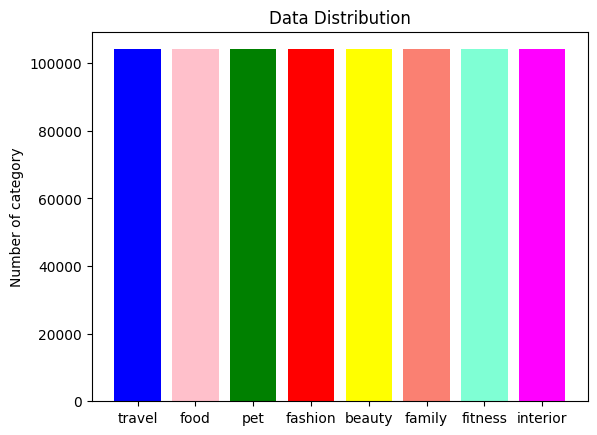

In [8]:
# Show the post distribution for each category 
df_vis = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/dataset_clean_complete.csv")
fig, ax = plt.subplots()
x = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior']
y = [df_vis.filter(col("label") == 'travel').count(),
     df_vis.filter(col("label") == 'food').count(),
     df_vis.filter(col("label") == 'pet').count(),
     df_vis.filter(col("label") == 'fashion').count(),
     df_vis.filter(col("label") == 'beauty').count(),
     df_vis.filter(col("label") == 'family').count(),
     df_vis.filter(col("label") == 'fitness').count(),
     df_vis.filter(col("label") == 'interior').count()]
ax.bar(x, y, color=['blue','pink','green','red','yellow','salmon','aquamarine', 'fuchsia'])
ax.set_ylabel('Number of category')
ax.set_title('Data Distribution')
plt.show()

In [13]:
df_vis.filter(col('label') =='travel').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='food').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='pet').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='fashion').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='beauty').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='family').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='fitness').select('label', 'post_metadata').show(1, 100)
df_vis.filter(col('label') =='interior').select('label', 'post_metadata').show(1, 100)

+------+----------------------------------------------------------------------------------------------------+
| label|                                                                                       post_metadata|
+------+----------------------------------------------------------------------------------------------------+
|travel|beautifuldestinations beautiful destinations beautifulhotels beautiful hotels prettylittleiiinspo...|
+------+----------------------------------------------------------------------------------------------------+
only showing top 1 row

+-----+----------------------------------------------------------------------------------------------------+
|label|                                                                                       post_metadata|
+-----+----------------------------------------------------------------------------------------------------+
| food|plaidcowsociety plaid cow society plaidcowsociety definitely delivered with their meat selec

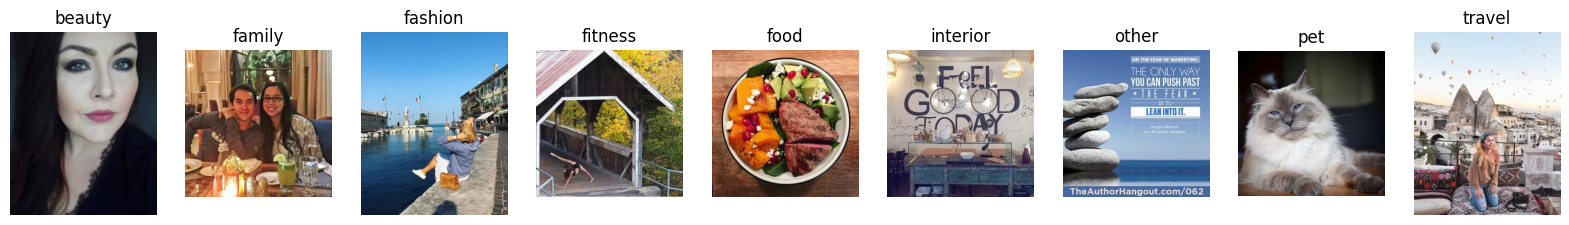

In [14]:
# Group the dataframe by category and select the first element for each group
f_unique = df_vis.groupBy('label').agg(first('post_images').alias('post_images'))

# Plot a single row and col for each category
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 5))

# Loop on categories and plot a category image
for i, row in enumerate(f_unique.collect()):
    img = Image.open(row['post_images'])

    axs[i].imshow(img)
    axs[i].set_title(row['label'])
    axs[i].axis('off')

plt.show()

# **Multimodal Post Encoder (Feature Engineering)**

---



## ***Text Features***








### BERT with SparkNLP

In [13]:
dataset_clean = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/dataset_clean_complete.csv")
dataset_clean = dataset_clean.filter(col('label') != 'other')
print(dataset_clean.count())

documentAssembler = DocumentAssembler() \
    .setInputCol("post_metadata") \
    .setOutputCol("document")
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
embeddings = BertEmbeddings.pretrained("bert_base_cased", "en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(128) \
    .setBatchSize(16)
embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["embeddings"]) \
    .setOutputCols("embeddingsFinisher") \
    .setCleanAnnotations(False)
pipeline = Pipeline().setStages([
        documentAssembler,
        tokenizer,
        embeddings,
        embeddingsFinisher])

print("Extraction in progress...")
result = pipeline.fit(dataset_clean).transform(dataset_clean).drop('embeddings', 'token', 'document', 'token').withColumn('post_representation', element_at('embeddingsFinisher', 1)).select('id', 'influencer_name', 'label', 'post_representation')

print("Extraction finished!")

result.show()
result.write.mode('overwrite').option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_sparknlp_complete.json")

832795
bert_base_cased download started this may take some time.
Approximate size to download 389,1 MB
[OK!]
Extraction in progress...
Extraction finished!
+----------+------------------+-----+--------------------+
|        id|   influencer_name|label| post_representation|
+----------+------------------+-----+--------------------+
|8589934592|avelthesiberiancat|  pet|[0.022017496, -0....|
|8589934593|avelthesiberiancat|  pet|[-0.20714694, -0....|
|8589934594|avelthesiberiancat|  pet|[-0.24940443, -0....|
|8589934595|avelthesiberiancat|  pet|[0.20243701, -0.3...|
|8589934596|avelthesiberiancat|  pet|[-0.29165858, 0.1...|
|8589934597|avelthesiberiancat|  pet|[-0.17585161, -0....|
|8589934598|avelthesiberiancat|  pet|[0.34634167, 0.37...|
|8589934599|avelthesiberiancat|  pet|[-0.3578648, -0.2...|
|8589934600|avelthesiberiancat|  pet|[0.48323157, 0.20...|
|8589934601|avelthesiberiancat|  pet|[-0.065826505, -0...|
|8589934602|avelthesiberiancat|  pet|[0.37101078, -0.5...|
|8589934603|avelth

## ***Image Features***

### Inception-V3

#### Data loading

In [7]:
dataset_clean = spark.read.option("header",True).csv(GDRIVE_DATA_DIR + "/dataset_clean_complete.csv").filter(col('label') != 'other')

float_converter_udf = udf(lambda id: float(id), DoubleType())

dataset_clean = dataset_clean.withColumn('id', float_converter_udf('id')).orderBy('id')

In [8]:
from my_dataset import ImageDataset
# Define a custom dataset class to load the input images
'''
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)
        label_tensor = torch.tensor(self.labels[idx])
        return image_tensor, label_tensor
'''

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(299),  # Resize the input image to 299x299
    transforms.CenterCrop(299),  # Crop the image to a square of size 299x299
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Define the image transformation pipeline
transform_online = transforms.Compose([
    transforms.RandomRotation(40),  # Rotate the image randomly up to 30 degrees
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Shift the image randomly up to 20% of its height and width
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Crop the image to a random size and aspect ratio, then resize it to 299x299
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust the brightness, contrast, saturation, and hue of the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


# Define a list of image paths
image_paths = [row.post_images for row in dataset_clean.collect()]

labelMap = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior', 'other']
labels_data = [labelMap.index(row.label) for row in dataset_clean.collect()]

# Create a custom dataset from the input image paths
img_dataset = ImageDataset(image_paths, labels_data, transform)

# Define the batch size and number of workers for the data loader
batch_size = 32
num_workers = 8

# Create a data loader from the dataset to parallelize the feature extraction process
data_loader = DataLoader(img_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
train_dataset, val_dataset, _ = dataset_clean.randomSplit([0.48, 0.12, 0.4], seed=42)

train_paths = [row.post_images for row in train_dataset.collect()]
    
labels_data = [labelMap.index(row.label) for row in train_dataset.collect()]

train_dataset = ImageDataset(train_paths, labels_data, transform_online)
train_dataset = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_paths = [row.post_images for row in val_dataset.collect()]

labels_data = [labelMap.index(row.label) for row in val_dataset.collect()]

val_dataset = ImageDataset(val_paths, labels_data, transform)
val_dataset = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

'''
# Datasets to be loaded to resume training
train_dataset = torch.load(GDRIVE_DATA_DIR + '/train_dataset.pt')
train_dataset = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = torch.load(GDRIVE_DATA_DIR + '/val_dataset.pt')
val_dataset = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

'''

In [ ]:
'''
#Save datasets for later training
print(train_dataset.dataset)
# Save the dataset to a file
torch.save(train_dataset.dataset, GDRIVE_DATA_DIR + '/train_dataset.pt')
torch.save(val_dataset.dataset, GDRIVE_DATA_DIR + '/val_dataset.pt')
'''

#### Inception-v3 fine tuning

In [ ]:
from my_dataset import ImageDataset

# Load the Inception-v3 model
model = models.inception_v3(pretrained=True)
#model = torch.load(GDRIVE_DATA_DIR + '/model_finetuned_new.pt').to(device)

# Freeze the layers except for the last two
for param in list(model.parameters())[:-2]:
    param.requires_grad = False
    
# Add global average pooling layer and a fully-connected layer
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 1024)
)

# move model on GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(trainable_params, lr=1e-3, momentum=0.9)


# Train the model on the dataset for our specific task
num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataset):    
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
                    
        optimizer.zero_grad()

        outputs = model(inputs).logits.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                
    print('Epoch %d loss: %.3f' % (epoch + 1, loss)) 

In [ ]:
# Validation
print('Validating...')
outputs = None
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for batch in tqdm(val_dataset):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test accuracy: {correct / total * 100}%') 
    

torch.save(model, GDRIVE_DATA_DIR + '/model_finetuned_new.pt')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(GDRIVE_DATA_DIR + '/model_scripted_finetuned_new.pt') # Save

#### Inception-v3 feature extraction

In [ ]:
model = torch.load(GDRIVE_DATA_DIR + '/model_finetuned_new.pt').to(device)

# Define a function to extract the features from a batch of images
def extract_features(images):    
    output_features = None
    model.eval()
    with torch.no_grad():
        output_features = model(images)
    return output_features

    
incv3_features = torch.tensor([]).to(device)
# Extract the features from the input images in parallel
for data in tqdm(data_loader):
    batch_images, labels = data
    batch_images = batch_images.to(device)
    incv3_features = torch.cat((incv3_features, extract_features(batch_images)), dim=0)

with open(GDRIVE_DATA_DIR + "/incv3_features.json", 'w') as f:
    json.dump(incv3_features.tolist(), f)
print(incv3_features.shape)
print(incv3_features)

## ***Saving inception-v3 features in dataframe***

In [ ]:
print('Loading file...')
with open(GDRIVE_DATA_DIR + "/incv3_features.json", 'r') as f:
    incv3_features = json.load(f)

print('File loading finished')

#CREATE CHUNKS#
end = len(incv3_features) // 10
print(end)
for n in range(10):
    chunk_name = 'chunk' + str(n)
    print(chunk_name)
    chunk = []
    if(n<9):
        chunk = incv3_features[end*n:end*(n+1)]
    else:
        chunk = incv3_features[end*n:]
    print(len(chunk))

    print('Saving '+chunk_name+'...')
    with open(GDRIVE_DATA_DIR + "/incv3_features_complete_chunks/"+chunk_name+".json", 'w') as f:
        json.dump(chunk, f)

In [ ]:
##CREATE DF CHUNKS
incv3_features = []
for n in tqdm(range(0, 10)):
    chunk_name = 'chunk' + str(n)
    print('Loading '+chunk_name+'...')
    file = None
    with open(GDRIVE_DATA_DIR + "/incv3_features_complete_chunks/"+chunk_name+".json", 'r') as f:
        file = json.load(f)

    print('Creating dataframe')
    post_representation_df = spark.createDataFrame([[feature_vector] for feature_vector in file], ['post_representation'])
    post_representation_df.write.mode('overwrite').option("header",True).json(GDRIVE_DATA_DIR + "/incv3_features_complete_chunks/df_"+chunk_name+".json")

In [ ]:
##READ DF CHUNKS AND MERGE
incv3_features = []
post_representation_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/incv3_features_complete_chunks/df_chunk0.json")
for n in tqdm(range(1, 10)):
    chunk_name = 'chunk' + str(n)
    print('Loading '+chunk_name+'...')

    print('Creating dataframe')
    post_representation_df = post_representation_df.union(spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/incv3_features_complete_chunks/df_"+chunk_name+".json"))

print('Saving dataframe')
post_representation_df.write.mode('overwrite').option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_inceptionv3.json")

## ***Dataframe Update***

In [9]:
dataset_clean = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_sparknlp_complete.json")

dataset_clean.show()
float_converter_udf = udf(lambda id: float(id), DoubleType())

# Unroll id column and change ids
dataset_clean = dataset_clean.withColumn('id', float_converter_udf('id')).orderBy('id')
dataset_clean = dataset_clean.withColumn("id", row_number().over(Window.orderBy("id"))).withColumnRenamed('post_representation', 'post_representation_bert')
dataset_clean.show()
print(dataset_clean.count())

post_representation_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_inceptionv3.json").withColumn("id", monotonically_increasing_id()).withColumn('id', float_converter_udf('id')).orderBy('id').withColumn("id", row_number().over(Window.orderBy("id"))).withColumnRenamed('post_representation', 'post_representation_incv3')
post_representation_df.show()
print(post_representation_df.count())

final_df = dataset_clean.join(post_representation_df, 'id')

print(final_df.count())
final_df.orderBy('id').show()
final_df.printSchema()

final_df.drop('post_representation_bert').withColumnRenamed('post_representation_incv3', 'post_representation').write.mode('overwrite').option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_inceptionv3_complete.json")

+----------+------------------+-----+--------------------+
|        id|   influencer_name|label| post_representation|
+----------+------------------+-----+--------------------+
|8589934592|avelthesiberiancat|  pet|[0.022017496, -0....|
|8589934593|avelthesiberiancat|  pet|[-0.20714694, -0....|
|8589934594|avelthesiberiancat|  pet|[-0.24940443, -0....|
|8589934595|avelthesiberiancat|  pet|[0.20243701, -0.3...|
|8589934596|avelthesiberiancat|  pet|[-0.29165858, 0.1...|
|8589934597|avelthesiberiancat|  pet|[-0.17585161, -0....|
|8589934598|avelthesiberiancat|  pet|[0.34634167, 0.37...|
|8589934599|avelthesiberiancat|  pet|[-0.3578648, -0.2...|
|8589934600|avelthesiberiancat|  pet|[0.48323157, 0.20...|
|8589934601|avelthesiberiancat|  pet|[-0.065826505, -0...|
|8589934602|avelthesiberiancat|  pet|[0.37101078, -0.5...|
|8589934603|avelthesiberiancat|  pet|[0.17750515, 0.10...|
|8589934604|avelthesiberiancat|  pet|[-0.06785521, -0....|
|8589934605|avelthesiberiancat|  pet|[-0.08459621, -0...

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "C:\Users\fed97\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 709, in readinto
    raise
TimeoutError: timed out


In [10]:
# feature concatenation
concat_df = final_df.withColumn('post_representation', concat('post_representation_incv3', 'post_representation_bert')).drop('post_representation_incv3', 'post_representation_bert')

In [ ]:
# export dataframe
concat_df.write.mode('overwrite').option("header",True).json(GDRIVE_DATA_DIR + "/dataset_with_features.json")

## ***Dataset Splitting***

In [7]:
final_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_sparknlp_complete.json").orderBy('id')
#final_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_inceptionv3_complete.json").orderBy('id')
#final_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_with_features.json").orderBy('id')
final_df.show()

final_df.groupBy('label').count().show()

# Ensure all influencers have exactly 300 posts
lstmp  = [row.influencer_name for row in final_df.groupBy('influencer_name', 'label').count().where(col('count') != 300).collect()]
final_df = final_df.filter(~col("influencer_name").isin(lstmp))

# Split the dataset in 200 influencer per category for the training and validation set, the rest for the testing set
total_number_influencer = final_df.groupBy(col('influencer_name')).count().count()
print('Total number of influencers: ' + str(total_number_influencer))
num_influencers_per_category = 200

partitioned_df = final_df.groupBy(col('influencer_name'), col('label')).count() \
                                  .orderBy(col('label')).withColumn("row_number", row_number() \
                                  .over(Window.partitionBy("label").orderBy('label')))

train_val_df = partitioned_df.filter(col('row_number') <= num_influencers_per_category)
test_df = final_df.join(partitioned_df.drop('label') \
                        .filter(col('row_number') > num_influencers_per_category), 'influencer_name') \
                        .select('id', 'influencer_name', 'label', 'post_representation')

# Split first dataset in training, validation
train_df, val_df = train_val_df.randomSplit([0.8, 0.2], seed=42)

train_df = final_df.join(train_df.drop('label'), 'influencer_name') \
                         .select('id', 'influencer_name', 'label', 'post_representation')


val_df = final_df.join(val_df.drop('label'), 'influencer_name') \
                         .select('id', 'influencer_name', 'label', 'post_representation')

print('Training Set:')
train_df.groupBy('influencer_name').count().orderBy('influencer_name').show(5)
print('Validation Set:')
val_df.groupBy('influencer_name').count().orderBy('influencer_name').show(5)                    
print('Testing Set:')
test_df.groupBy('influencer_name').count().orderBy('influencer_name').show(5)

+---+---------------+------+--------------------+
| id|influencer_name| label| post_representation|
+---+---------------+------+--------------------+
|  1|         annszi|travel|[10.8230905532836...|
|  2|         annszi|travel|[18.2518653869628...|
|  3|         annszi|travel|[13.5605335235595...|
|  4|         annszi|travel|[10.3835926055908...|
|  5|         annszi|travel|[10.1343383789062...|
|  6|         annszi|travel|[15.7205667495727...|
|  7|         annszi|travel|[12.4533128738403...|
|  8|         annszi|travel|[13.9307632446289...|
|  9|         annszi|travel|[13.2190656661987...|
| 10|         annszi|travel|[14.2992668151855...|
| 11|         annszi|travel|[13.5529832839965...|
| 12|         annszi|travel|[10.8469314575195...|
| 13|         annszi|travel|[8.30574798583984...|
| 14|         annszi|travel|[7.82807064056396...|
| 15|         annszi|travel|[12.6720037460327...|
| 16|         annszi|travel|[12.5782480239868...|
| 17|         annszi|travel|[9.19608116149902...|


# **Post Attentive Influencer Encoder**

---



## ***Data format fixing and machine learning preparation***

In [8]:
train_temp = train_df.groupBy('influencer_name', 'label').agg(collect_list("post_representation").alias("influencer_representation")).filter(col('label') != 'other').repartition(24)
val_temp = val_df.groupBy('influencer_name', 'label').agg(collect_list("post_representation").alias("influencer_representation")).filter(col('label') != 'other').repartition(24)
test_temp = test_df.groupBy('influencer_name', 'label').agg(collect_list("post_representation").alias("influencer_representation")).filter(col('label') != 'other').repartition(24)

train_temp = train_temp.filter(size('influencer_representation') == 300)
val_temp = val_temp.filter(size('influencer_representation') == 300)
test_temp = test_temp.filter(size('influencer_representation') == 300)

In [ ]:
labelMap = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior', 'other']

trt = train_temp.collect()
train_set = TensorDataset(torch.tensor([row.influencer_representation for row in tqdm(trt)]), torch.tensor([labelMap.index(row.label) for row in trt]))
del trt

vtt = val_temp.collect()
val_set = TensorDataset(torch.tensor([row.influencer_representation for row in tqdm(vtt)]), torch.tensor([labelMap.index(row.label) for row in vtt]))
del vtt

tet = test_temp.collect()
test_set = TensorDataset(torch.tensor([row.influencer_representation for row in tqdm(tet)]), torch.tensor([labelMap.index(row.label) for row in tet]))
del tet

torch.save(train_set, GDRIVE_DATA_DIR + '/train_set_bert.pt')
torch.save(val_set, GDRIVE_DATA_DIR + '/val_set_bert.pt')
torch.save(test_set, GDRIVE_DATA_DIR + '/test_set_bert.pt')

print(train_temp.count())
print(val_temp.count())
print(test_temp.count())

## Useful functions 

In [9]:
def plotConfusionMatrix(preds, labels, name = ""):
    cm = confusion_matrix(preds['label_index'], preds['prediction'])
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix {name}'); 
    ax.xaxis.set_ticklabels(labels, fontsize=8); ax.yaxis.set_ticklabels(labels[::-1], fontsize=8);  
    plt.show()

def plotTrainValEpochAccuracy(train_accu, val_accu):
    plt.plot(train_accu,'-o')
    plt.plot(val_accu,'-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training','Validation'])
    plt.title('Training vs Validation Accuracy')     
    plt.show()

def plotTrainValEpochLoss(train_losses, val_losses):
    plt.plot(train_losses,'-o')
    plt.plot(val_losses,'-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training','Validation'])
    plt.title('Training vs Validation Losses')
     
    plt.show()

## Create influencer embedding using attention mechanism 

### Neural network functions

In [10]:
class AdditiveAttention(nn.Module):
    """
     Applies a additive attention (bahdanau) mechanism on the output features from the decoder.
     Additive attention proposed in "Neural Machine Translation by Jointly Learning to Align and Translate" paper.

     Args:
         hidden_dim (int): dimesion of hidden state vector

     Inputs: query, value
         - **query** (batch_size, q_len, hidden_dim): tensor containing the output features from the decoder.
         - **value** (batch_size, v_len, hidden_dim): tensor containing post features

     Returns: context, attn
         - **context**: tensor containing the context vector from attention mechanism.
         - **attn**: tensor containing the alignment from the encoder outputs.

     Reference:
         - **Neural Machine Translation by Jointly Learning to Align and Translate**: https://arxiv.org/abs/1409.0473
    """
    def __init__(self, hidden_dim: int) -> None:
        super(AdditiveAttention, self).__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bias = nn.Parameter(torch.rand(hidden_dim).uniform_(-0.1, 0.1))
        self.score_proj = nn.Linear(hidden_dim, 1)

    def forward(self, value: Tensor) -> Tensor:
        
        score = self.score_proj(torch.tanh(self.key_proj(value) + self.query_proj(value) + self.bias)).squeeze(-1)

        attn = F.softmax(score, dim=-1)
        context = torch.bmm(attn.unsqueeze(1), value)
        return context

class InfluencerClassification(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(InfluencerClassification, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU())
        
        self.attention = AdditiveAttention(hidden_dim)
        self.cc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, setpost):
        # posts shape: (batch_size, seq_len, hidden_dim)
        setpost = self.fc(setpost)
        
        # Compute attention
        embedding = self.attention(setpost)  # (batch_size, 1, hidden_dim), (batch_size, seq_len)

        # Remove the temporal dimension
        embedding = embedding.squeeze(1)  # (batch_size, hidden_dim)

        # Pass through fully connected layers
        logits = self.cc(embedding)

        return logits

def nnTrain(model, trainLoader, valLoader, criterion, optimizer, epochs):
    train_accu=[]
    train_losses=[]
    val_accu=[]
    val_losses=[]
    
    for epoch in tqdm(range(epochs)):
        model.train()    
        running_loss=0
        correct=0
        total=0     
        for batch in trainLoader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
         
            running_loss += loss.item()
             
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_loss=running_loss/len(trainLoader)
        accu=100.*correct/total
           
        train_accu.append(accu)
        train_losses.append(train_loss)

        # Validation 
        model.eval()
        with torch.no_grad():
            running_lossVal = 0
            totalVal = 0
            correctVal = 0
            for batch in valLoader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                running_lossVal += loss.item()
                totalVal += targets.size(0)
                correctVal += (predicted == targets).sum().item()

            val_loss=running_lossVal/len(valLoader)
            accuVal=100.*correctVal/totalVal
               
            val_accu.append(accuVal)
            val_losses.append(val_loss)
                        
    return train_accu, train_losses, val_accu, val_losses
       

def nnTest(model, testLoader):
    # Test
    print('Testing...')
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(testLoader):
            inputs, targets = batch
            y_true += targets.tolist()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.tolist()

    target_names = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior']
    # y_true: true labels, y_pred: predicted labels
    print(classification_report(y_true, y_pred, target_names=target_names))
    plotConfusionMatrix({'label_index':y_true, 'prediction':y_pred}, labels=target_names, name = "Influencer Scouting")
    

def nnSaveModel(model):
    torch.save(model, GDRIVE_DATA_DIR + '/model_nn_bert.pt')
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(GDRIVE_DATA_DIR + '/model_nn_scripted_bert.pt') # Save

### Neural network execution

In [ ]:
batch_size = 32

train_set = torch.load(GDRIVE_DATA_DIR + '/train_set_bert.pt')
val_set = torch.load(GDRIVE_DATA_DIR + '/val_set_bert.pt')
test_set = torch.load(GDRIVE_DATA_DIR + '/test_set_bert.pt')

# Create a DataLoader to iterate over the dataset
trainLoader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Instantiate the model
model = InfluencerClassification(input_dim=768, hidden_dim=256, output_dim=8, dropout_prob=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
epochs = 50
train_accu, train_losses, val_accu, val_losses = nnTrain(model, trainLoader, valLoader, criterion, optimizer, epochs)
plotTrainValEpochAccuracy(train_accu, val_accu)
plotTrainValEpochLoss(train_losses, val_losses)
nnTest(model, testLoader)
nnSaveModel(model)

# **Model baselines**


---

### **Useful functions**

In [7]:
def plotConfusionMatrix(preds, name = ""):
    cm = confusion_matrix(preds['label_index'], preds['prediction'])
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    
    target_names = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior']
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix {name}'); 
    ax.xaxis.set_ticklabels(target_names, fontsize=8); ax.yaxis.set_ticklabels(target_names[::-1], fontsize=8);  
    plt.show()

# create a MulticlassClassificationEvaluator to compute accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction")

def performEvaluation(model, test_set,  name = "", evaluator = evaluator):
    cols = ['label_index', 'prediction']
        
    # make predictions on the testing data
    print('Evaluating...')
    predictions = model.transform(test_set)
        
    predictions = predictions.select(*cols).toPandas()
    target_names = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior']
    report = classification_report(predictions['label_index'], predictions['prediction'], target_names=target_names)
    print(report)    
    
    plotConfusionMatrix(predictions, name = name)

### **Spark data formatting**

In [8]:
print('Loading dataframe...')
full_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_sparknlp_complete.json")
#full_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_from_inceptionv3_complete.json")
#full_df = spark.read.option("header",True).json(GDRIVE_DATA_DIR + "/dataset_with_features.json").filter(col('label') != 'other')

full_df.show()

print('Averaging post representations...')
vectore_size = 768 #size of array column for bert
#vectore_size = 1024 #size of array column for inception-v3
#vectore_size = 1792 #size of array column for feature concatenation

full_df = full_df.select('influencer_name', 'label', *[col("post_representation")[i] for i in range(vectore_size)])
full_df = full_df.groupby('influencer_name', 'label').agg(array([mean(i) for i in full_df.columns[2:]]).alias("Average_post_feature"))

print('Applying index tranformation...')
labelMap = ['travel', 'food', 'pet', 'fashion', 'beauty', 'family', 'fitness', 'interior', 'other']
label_index_udf = udf(lambda label: labelMap.index(label), IntegerType())
full_df = full_df.withColumn('label_index', label_index_udf('label'))

print('Converting in dense vectors...')
to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())
full_df = full_df.withColumn('Average_post_feature', to_vector_udf('Average_post_feature'))

# Normalize the input data
print('Scaling features...')

scaler = StandardScaler(inputCol="Average_post_feature", outputCol="scaledFeatures", withStd=True, withMean=True)
standardScaler = scaler.fit(full_df)
full_df = standardScaler.transform(full_df).drop("Average_post_feature").withColumnRenamed("scaledFeatures", "Average_post_feature")

Loading dataframe...
+---+---------------+------+--------------------+
| id|influencer_name| label| post_representation|
+---+---------------+------+--------------------+
|  1|         annszi|travel|[10.8230905532836...|
|  2|         annszi|travel|[18.2518653869628...|
|  3|         annszi|travel|[13.5605335235595...|
|  4|         annszi|travel|[10.3835926055908...|
|  5|         annszi|travel|[10.1343383789062...|
|  6|         annszi|travel|[15.7205667495727...|
|  7|         annszi|travel|[12.4533128738403...|
|  8|         annszi|travel|[13.9307632446289...|
|  9|         annszi|travel|[13.2190656661987...|
| 10|         annszi|travel|[14.2992668151855...|
| 11|         annszi|travel|[13.5529832839965...|
| 12|         annszi|travel|[10.8469314575195...|
| 13|         annszi|travel|[8.30574798583984...|
| 14|         annszi|travel|[7.82807064056396...|
| 15|         annszi|travel|[12.6720037460327...|
| 16|         annszi|travel|[12.5782480239868...|
| 17|         annszi|travel|[

#### **Principal Component Analysis**

Computing PCA...


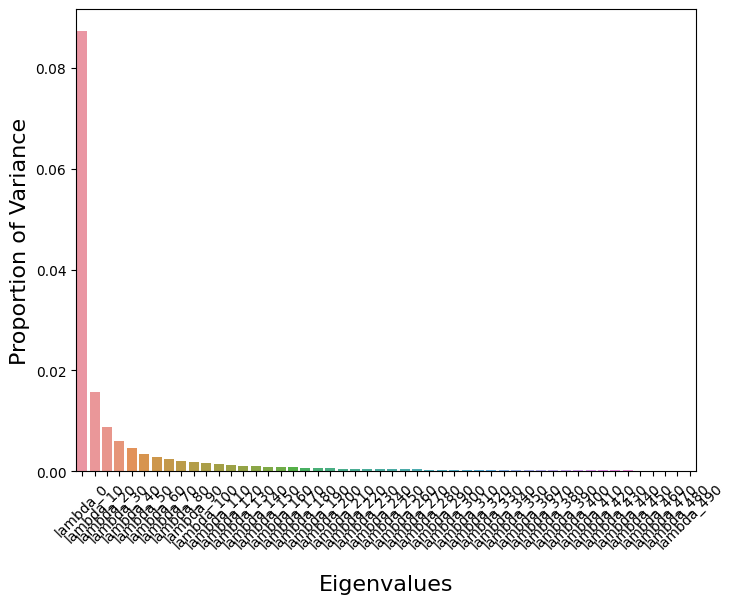

In [22]:
print('Computing PCA...')

k = 500 

pca = PCA(k=k, inputCol="Average_post_feature", outputCol="pcaFeatures")
pcaModel = pca.fit(full_df)

fig, ax = plt.subplots(1,1,figsize=(8,6))
_ = sns.barplot(x=[i for i in range(0, k, 10)],
                y=[pcaModel.explainedVariance.values[i] for i in range(0, len(pcaModel.explainedVariance.values), 10)], # `explainedVariance` returns the distribution of variance across eigenvectors, i.e., lambda_i/sum lambda_i
                ax=ax)
_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(["lambda_{:d}".format(i) for i in range(0, k, 10)], rotation=45)


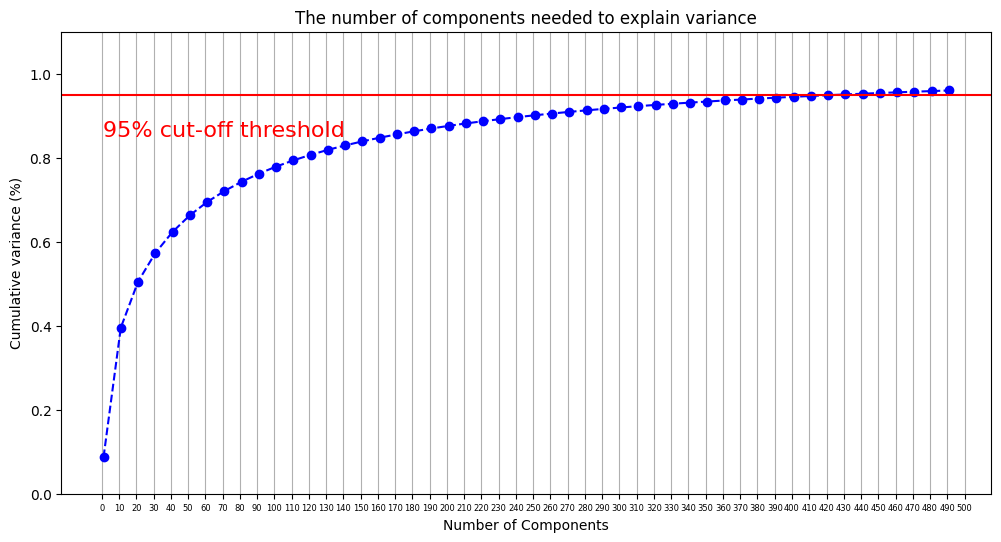

In [23]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, k+1, step=10)
y = np.cumsum(pcaModel.explainedVariance)
y = [y[i] for i in range(0, len(y), 10)]

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, k+1, step=10), fontsize=6) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [25]:
pca = PCA(k=420, inputCol="Average_post_feature", outputCol="pcaFeatures") #k=138 for Bert #k=420 for concatenated features
pcaModel = pca.fit(full_df)

# Transform the data using the PCA model
full_df_pca = pcaModel.transform(full_df).drop("Average_post_feature").withColumnRenamed("pcaFeatures", "Average_post_feature")

print('Splitting...')
train_set_pca, test_set_pca = full_df_pca.randomSplit([0.6, 0.4], seed=42)

print('Shuffling training set...')
train_set_pca = train_set_pca.withColumn("random", rand()).orderBy("random").drop("random")

train_set_pca = train_set_pca.repartition(24)
test_set_pca = test_set_pca.repartition(24)

Splitting...
Shuffling training set...


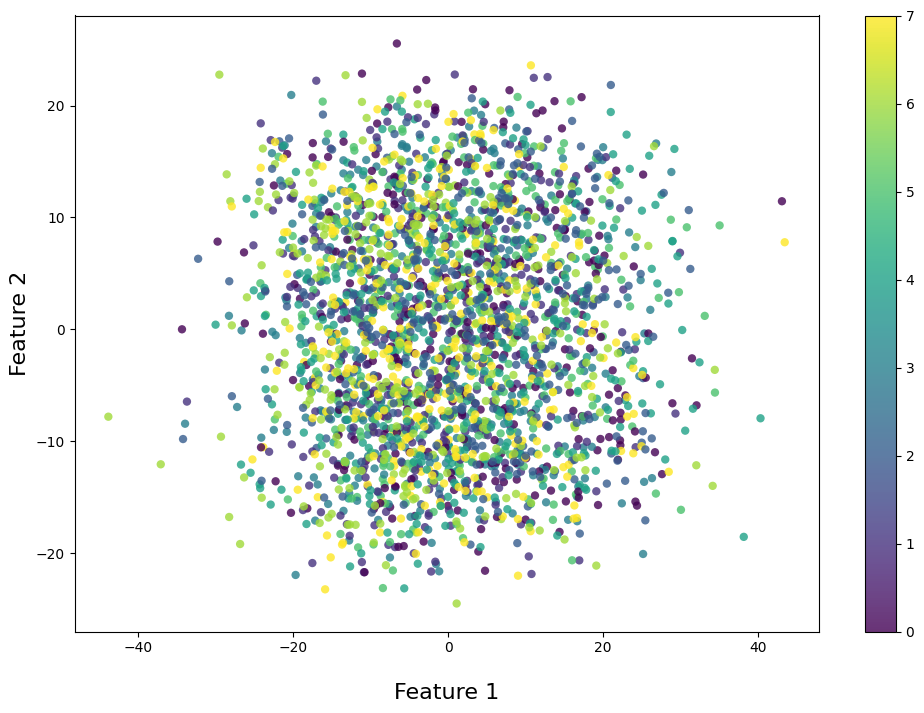

In [26]:
ls = full_df_pca.collect()
pca1 = [row.Average_post_feature[0] for row in ls]
pca2 = [row.Average_post_feature[1] for row in ls]
labels = [row.label_index for row in ls]

fig, ax = plt.subplots(1,1,figsize=(12,8))
_ = plt.scatter(
    pca1,
    pca2,
    c=labels,
    edgecolor='none',
    alpha=0.8,
    axes=ax
    )
_ = ax.set_xlabel('Feature 1', labelpad=20, fontsize = 16)
_ = ax.set_ylabel('Feature 2', fontsize = 16)
plt.colorbar()

#### **Splitting dataset**

In [60]:
print('Splitting...')
train_set, test_set = full_df.randomSplit([0.6, 0.4], seed=42)

print('Shuffling training set...')
train_set = train_set.withColumn("random", rand()).orderBy("random").drop("random")

train_set = train_set.repartition(24)
test_set = test_set.repartition(24)

train_set.printSchema()

Splitting...
Shuffling training set...
root
 |-- influencer_name: string (nullable = true)
 |-- label: string (nullable = true)
 |-- label_index: integer (nullable = true)
 |-- Average_post_feature: vector (nullable = true)



### ***1. Gaussian Naive Bayes***

In [29]:
model = NaiveBayes(labelCol="label_index", featuresCol="Average_post_feature")

scaler = MinMaxScaler(inputCol="Average_post_feature", outputCol="scaledFeatures")  
minMaxScaler = scaler.fit(full_df_pca)
train_set_pca_scaled = minMaxScaler.transform(train_set_pca).drop("Average_post_feature").withColumnRenamed("scaledFeatures", "Average_post_feature")
test_set_pca_scaled = minMaxScaler.transform(test_set_pca).drop("Average_post_feature").withColumnRenamed("scaledFeatures", "Average_post_feature")

print('Training...')

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(model.smoothing, [0.5, 0.7, 1.0, 1.3, 1.5, 2.0])\
    .addGrid(model.modelType, ["multinomial"])\
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=model,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_set_pca_scaled)


Training...


Evaluating...
              precision    recall  f1-score   support

      travel       1.00      0.01      0.03       149
        food       0.17      0.88      0.29       123
         pet       1.00      0.05      0.10       146
     fashion       0.62      0.09      0.16       142
      beauty       0.23      0.78      0.35       126
      family       0.57      0.18      0.28       137
     fitness       1.00      0.01      0.01       165
    interior       1.00      0.05      0.10       146

    accuracy                           0.23      1134
   macro avg       0.70      0.26      0.17      1134
weighted avg       0.72      0.23      0.16      1134



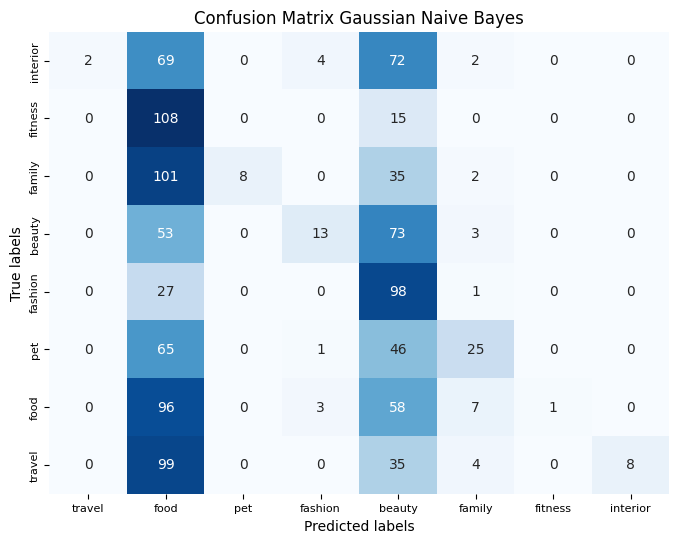

In [30]:
performEvaluation(model, test_set_pca_scaled, name = "Gaussian Naive Bayes")

### ***2. Random Forest***

In [20]:
model = RandomForestClassifier(labelCol="label_index", featuresCol="Average_post_feature", seed=42)

print('Training...')

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [6, 9, 12]) \
    .addGrid(model.numTrees, [50, 100, 200]) \
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=model,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_set_pca)


Training...


Evaluating...
              precision    recall  f1-score   support

      travel       0.36      0.32      0.34       149
        food       0.39      0.66      0.49       123
         pet       0.67      0.53      0.60       146
     fashion       0.33      0.34      0.34       142
      beauty       0.35      0.60      0.44       126
      family       0.29      0.33      0.31       137
     fitness       0.53      0.18      0.26       165
    interior       0.47      0.35      0.40       146

    accuracy                           0.40      1134
   macro avg       0.42      0.41      0.40      1134
weighted avg       0.43      0.40      0.39      1134



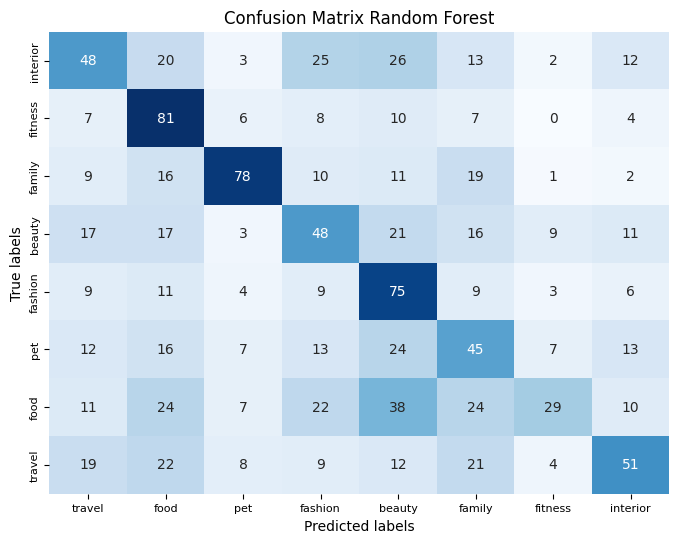

In [21]:
performEvaluation(model, test_set_pca, name = "Random Forest")

### ***3. Logistic Regression***

In [13]:
model = LogisticRegression(labelCol="label_index", featuresCol="Average_post_feature")
print('Training...')

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(model.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(model.maxIter, [10, 100, 1000]) \
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=model,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_set_pca)


Training...


Evaluating...
              precision    recall  f1-score   support

      travel       0.64      0.61      0.62       149
        food       0.71      0.77      0.74       123
         pet       0.87      0.76      0.81       146
     fashion       0.45      0.50      0.47       142
      beauty       0.61      0.75      0.68       126
      family       0.47      0.56      0.51       137
     fitness       0.67      0.53      0.59       165
    interior       0.76      0.63      0.69       146

    accuracy                           0.63      1134
   macro avg       0.65      0.64      0.64      1134
weighted avg       0.65      0.63      0.64      1134



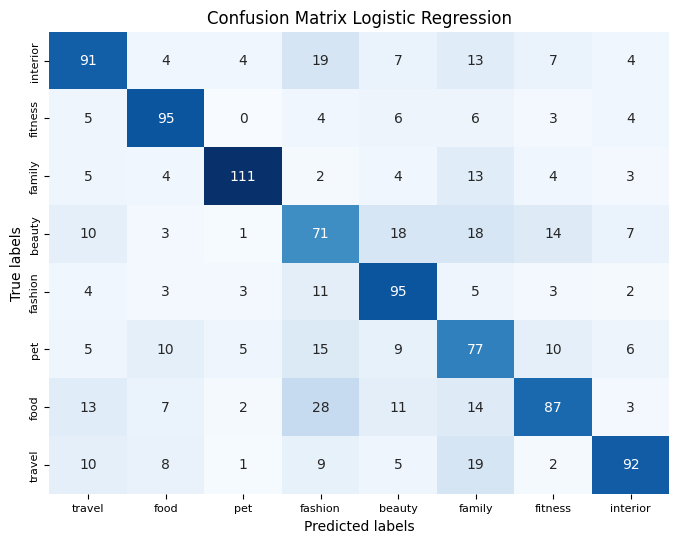

In [14]:
performEvaluation(model, test_set_pca, name = "Logistic Regression")